In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [2]:
# Load Food Dataset and Nutrition CSV
foodimg_dir = 'Indian Food Images'
nutrition_data = pd.read_csv('new_cal.csv')

In [3]:
# Ensure column names are clean
nutrition_data.columns = nutrition_data.columns.str.strip()

In [4]:
# Preprocess images (resize and normalize)
def preprocess_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to training and validation directories
train_dir = "Indian Food Images/Train"
val_dir = "Indian Food Images/val"

# ImageDataGenerator for training (with data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,   # Normalize pixel values
    rotation_range=30, # Augmentation options
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# ImageDataGenerator for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Change if using binary classification
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 200 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [6]:
# Build and Train CNN Model (MobileNetV2 + Custom Layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Train the model (Increase epochs for better learning)
#model.fit(train_data, epochs=10, validation_data=val_data)

In [9]:
history = model.fit(train_data, epochs=10, validation_data=val_data)


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.2542 - loss: 1.6142 - val_accuracy: 0.6200 - val_loss: 1.0754
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8571 - loss: 0.7692 - val_accuracy: 0.8200 - val_loss: 0.6545
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8854 - loss: 0.4518 - val_accuracy: 0.7800 - val_loss: 0.6089
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9309 - loss: 0.2708 - val_accuracy: 0.7800 - val_loss: 0.5708
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9624 - loss: 0.1562 - val_accuracy: 0.8600 - val_loss: 0.3905
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9987 - loss: 0.0656 - val_accuracy: 0.8800 - val_loss: 0.2770
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9909 - loss: 0.0585 - val_accuracy: 0.9400 - val_loss: 0.2245
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9770 - loss: 0.0626 - val_accuracy: 0.9000 - val_loss: 0.2125
Epoch 9/

In [10]:
model.save('NutriTrack4545.h5')

In [11]:
def get_food_info(food_label):
    # Normalize "Food Item" for comparison
    result = nutrition_data[nutrition_data['Food Item'].str.lower().str.strip() == food_label.lower().strip()]
    
    if not result.empty:
        # Convert to list for safe indexing
        food_info = result[['Calories', 'Proteins', 'Carbs', 'Quantity']].iloc[0].tolist()
        return food_info
    
    return None  # Explicitly return None when no match is found


In [12]:
def test_model(test_image_path):
    img = preprocess_image(test_image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    prediction = model.predict(img)
    print(f"Raw Prediction: {prediction}")

    # Get the predicted class
    food_label = train_data.class_indices
    predicted_food = list(food_label.keys())[np.argmax(prediction)]

    # Retrieve food information
    food_info = get_food_info(predicted_food)

    if food_info:  # Check if info is available
        calories, proteins, carbs, quantity = food_info
        print(f'Predicted food: {predicted_food}, Quantity: {quantity}, Calories: {calories}, Proteins: {proteins}, Carbs: {carbs}')
    else:
        print(f'Predicted food: {predicted_food}, Information not found')


In [16]:
test_model('Indian Food Images/val/chicken_tikka/34d3315ead.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Raw Prediction: [[0.01652747 0.00241788 0.74595875 0.08647862 0.14861733]]
Predicted food: chicken_tikka, Quantity: 100g (1 serving), Calories: 300, Proteins: 28, Carbs: 5


***✅ 1. Model Accuracy and Loss Graphs***<br>
These show how your model improves over each epoch during training.

📊 Graphs:
Training vs Validation Accuracy

Training vs Validation Loss

✅ Why:
These graphs help to demonstrate:

If your model is learning properly

If there is overfitting (validation accuracy stagnates or drops while training accuracy increases)

If the model is underfitting (both accuracies are low)

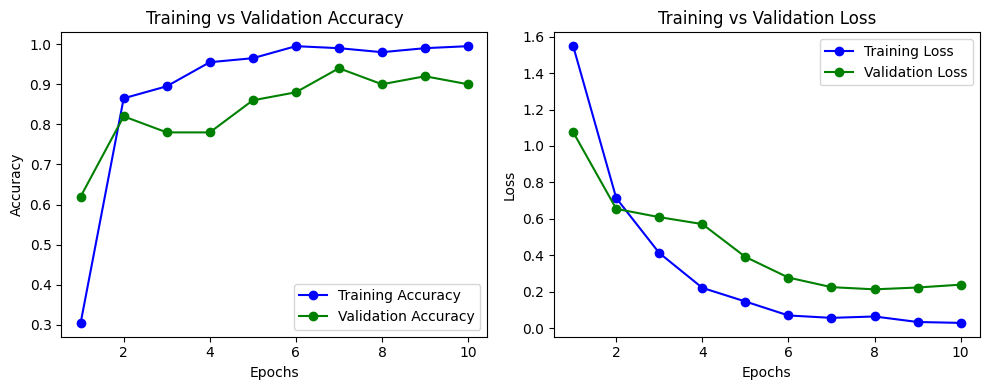

In [17]:
import matplotlib.pyplot as plt

# Assuming `history` is the output of model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


***✅ 2. Confusion Matrix (After Evaluation)***<br>
To visualize how well your model classifies each class.

✅ Why:
Shows misclassifications

Useful for understanding per-class accuracy

Found 50 images belonging to 5 classes.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


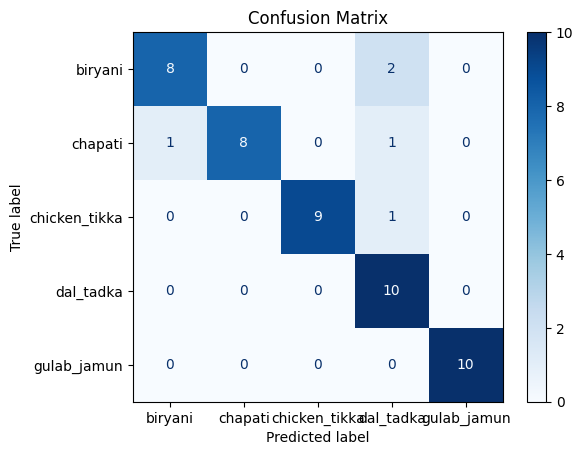

In [24]:
# 1. Load your validation data the same way you did during training
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: to match order with labels
)

# 2. Predict
y_pred_probs = model.predict(val_data)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 3. Get true labels from generator
y_true_labels = val_data.classes  # These are actual class indices

# 4. Get class names (from folder structure)
class_names = list(val_data.class_indices.keys())

# 5. Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


***✅ 4. Class Distribution of Training Data***<br>
Graph: Bar Chart of the number of images per food class in your dataset.

📊 Why include it?
Shows whether your dataset is balanced or imbalanced (which can affect model performance).

Helps justify data augmentation or weighted loss functions (if used).

✅ Code:

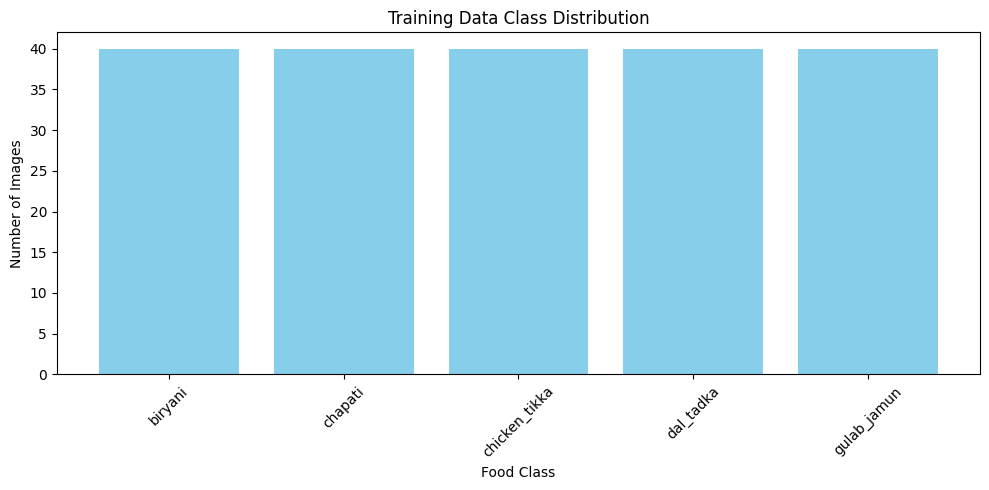

In [30]:
import os
import matplotlib.pyplot as plt

# Assuming you have folders like "images/train/FoodName"
food_classes = os.listdir("Indian Food Images/Train")
class_counts = [len(os.listdir(f"Indian Food Images/Train/{cls}")) for cls in food_classes]

plt.figure(figsize=(10, 5))
plt.bar(food_classes, class_counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Training Data Class Distribution")
plt.xlabel("Food Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


***✅ 5. Learning Rate Scheduler Graph (Only if you used one)***<br>
Graph: Plot of learning rate over epochs.

📊 Why include it?
Shows how learning rate changes over time if you used techniques like ReduceLROnPlateau, StepDecay, or Cyclical Learning Rate.

Helps explain changes in model performance.

In [32]:
# If you used a LearningRateScheduler or callback that logs learning rate:
lrs = history.history.get("lr")  # Sometimes saved as "lr" or "learning_rate"
if lrs:
    plt.plot(lrs)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()


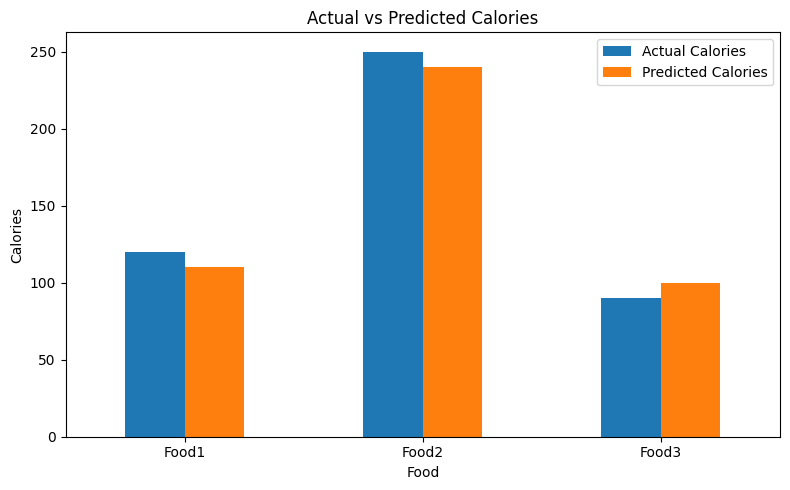

In [35]:
import seaborn as sns
import pandas as pd

# Example DataFrame of predictions vs ground truth
df = pd.DataFrame({
    'Food': ['Food1', 'Food2', 'Food3'],
    'Actual Calories': [120, 250, 90],
    'Predicted Calories': [110, 240, 100]
})

df.plot(x='Food', kind='bar', figsize=(8,5))
plt.title('Actual vs Predicted Calories')
plt.ylabel('Calories')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


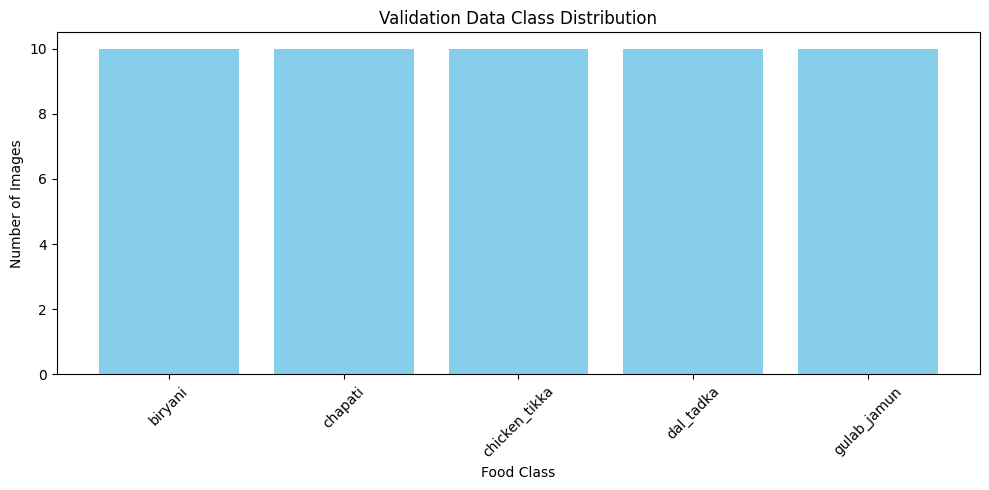

In [3]:
import os
import matplotlib.pyplot as plt

# Assuming you have folders like "images/train/FoodName"
food_classes = os.listdir("Indian Food Images/val")
class_counts = [len(os.listdir(f"Indian Food Images/val/{cls}")) for cls in food_classes]

plt.figure(figsize=(10, 5))
plt.bar(food_classes, class_counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Validation Data Class Distribution")
plt.xlabel("Food Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

